#Analysis of 5 smFRET samples

In this notebook:

* Per-sample FRET histograms
* Collapsed (merged channels) FRET histograms
* FRET vs distance plot (multi-spot vs usALEX)
* D-only fraction plots
* Burst size vs measurement (corrected and uncorrected)
* Background (per CH) vs measuremets
* Burst-per-second (per CH) vs measuremet
* Burst accumulation vs time (per CH and all-CH)

> **USAGE TIP**: to comment-out a code cell, select all (CTRL+a) and hit CTRL+/.

##FRET fitting remarks

In this notebook we fit the Proximity Ratio histogram using different models.

##Load FRETBursts software

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
-------------------------------------------------------------


 You are running FRETBursts (version 0.4rc10-7-gb2e1b5d).

 If you use this software in a publication, please cite it as:

   FRETBursts - An opensource single-molecule FRET bursts analysis toolkit.
   A. Ingargiola 2014. https://github.com/tritemio/FRETBursts

-------------------------------------------------------------


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
import os
from IPython.display import display, Math
%matplotlib inline

In [3]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import display
from IPython.utils.traitlets import link

In [4]:
import lmfit
print 'lmfit version:', lmfit.__version__

lmfit version: 0.8.3


##8-spot paper plot style

In [5]:
PLOT_DIR = './figure/'

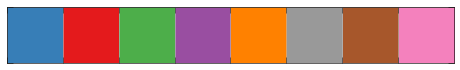

In [6]:
import seaborn as sns
%run -i styles/style.py
#np.set_printoptions(formatter={'float': lambda x: '%6.2f'%x})
import matplotlib as mpl

# brewer2mpl.get_map args: set name  set type  number of colors
#bmap = brewer2mpl.get_map('Set1', 'qualitative', 9)
bmap = sns.color_palette("Set1", 9)
colors = np.array(bmap)[(1,0,2,3,4,8,6,7), :]
mpl.rcParams['axes.color_cycle'] = list(colors)
colors_labels = ['blue', 'red', 'green', 'violet', 'orange', 'gray', 'brown', 'pink', ]
for c, cl in zip(colors, colors_labels):
    locals()[cl] = tuple(c) # assign variables with color names
sns.palplot(colors)

##Data files

Data folder:

In [7]:
data_dir = './data/2013-05-15/'

Check that the folder exists:

In [8]:
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

List of data files in `data_dir`:

In [9]:
from glob import glob
file_list = sorted(glob(data_dir + '*.hdf5'))

In [10]:
## Selection for POLIMI 2012-11-26 datatset
labels = ['12d', '17d', '22d', '27d', '7d', 'DO']
files_dict = {lab: fname for lab, fname in zip(labels, file_list)}
files_dict

{'12d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\12d_New_30p_320mW_steer_3.hdf5',
 '17d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\17d_100p_320mW_steer_1.hdf5',
 '22d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\22d_30p_320mW_steer_1.hdf5',
 '27d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\27d_50p_320mW_steer_1.hdf5',
 '7d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\7d_New_150p_320mW_steer_3.hdf5',
 'DO': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\DO12_No2_50p_320mW_steer_1.hdf5'}

## Parameters from file

Load the **leakage coefficient** from disk (computed in [Multi-spot 5-Samples analyis - Leakage coefficient fit](Multi-spot 5-Samples analyis - Leakage coefficient fit.ipynb)):

In [11]:
leakage_coeff_fname = 'results/Multi-spot - leakage coefficient Dem.txt'
leakage = np.loadtxt(leakage_coeff_fname, ndmin=1)

print 'Leakage coefficient:', leakage

Leakage coefficient: [ 0.03340331]


Load the **direct excitation coefficient** ($d_{exT}$) from disk (computed in [usALEX - Corrections - Direct excitation physical parameter](usALEX - Corrections - Direct excitation physical parameter.ipynb)):

In [12]:
dir_ex_coeff_fname = 'results/usALEX - direct excitation coefficient dir_ex_t.txt'
dir_ex_t = np.loadtxt(dir_ex_coeff_fname, ndmin=1)

print 'Direct excitation coefficient (dir_ex_t):', dir_ex_t

Direct excitation coefficient (dir_ex_t): [ 0.0464311]


##Parameters

Analysis parameters:

In [13]:
gamma_pre = 1.       # Applied before FRET fit (used to correct burst data)
gamma_post = 0.42    # Applied after FRET fit (used to correct fitted E)
gamma_fit = 0.42     # Used to compute burst weights for the fit
gamma1_sel = 0.42    # Used to compute burst size during burst selection

hist_weights = 'size'

## Background fit parameters
bg_kwargs_auto = dict(fun=bg.exp_fit,
                 time_s = 30,
                 tail_min_us = 'auto',
                 F_bg=1.7,
                 )

## Burst search
F=6
dither = False
size_th = 30    # Burst size threshold (selection on corrected burst sizes)

## FRET fit parameters
bandwidth = 0.03        # KDE bandwidth
E_range = {'7d':  (0.7, 1.0), '12d': (0.4, 0.8), '17d': (0.2, 0.4), 
           '22d': (0.0, 0.1), '27d': (0.0, 0.1), 'DO': (0.0, 0.1)}
E_axis_kde = np.arange(-0.2, 1.2, 0.0002)

Processing and plot options:

In [14]:
# Data load options
reload_data = 1
burst_search = 1
delete_ph_times = 0

# Per-sample plots
bg_plot = 0          # Plot background vs time, ph_times are needed
timetrace_plot = 0   # Plot timetrace, ph_times are needed
fret_plot = 1        # Plot FRET histograms

# All-samples plots
fret_dist_plot = 1
deviance_plot = 1

# Plot output options
save_figure = 0
nosuptitle = False

plt.rc('savefig', dpi=75)  # Changes the figure size in the notebook
savefig_kwargs =  dict(dpi=200, bbox_inches='tight')  # default save-figure options

fret_plot_kw = dict(bins = r_[-0.2:1.201:bandwidth],
                    fit_color='k', fit_alpha=0.9, fit_lw=2, #fit_fillcolor='#888888',
                    sharey = False)

In [15]:
# Make sure there is no error in the gamma definitions
assert ((gamma_pre == 1) and (gamma_post == gamma_fit)) or \
       ((gamma_post == 1) and (gamma_pre == gamma_fit))

##Utility functions

In [16]:
def print_fit_report(E_pr, gamma=1, leakage=0, dir_ex_t=0, math=True):
    """Print fit and standard deviation for both corrected and uncorrected E
    Returns d.E_fit.
    """
    E_corr = fretmath.correct_E_gamma_leak_dir(E_pr, gamma=gamma, leakage=leakage, dir_ex_t=dir_ex_t)
    
    E_pr_mean = E_pr.mean()*100
    E_pr_delta = (E_pr.max() - E_pr.min())*100
    
    E_corr_mean = E_corr.mean()*100
    E_corr_delta = (E_corr.max() - E_corr.min())*100
    if math:
        display(Math(r'\text{Pre}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_pr_mean, E_pr_delta)))
        display(Math(r'\text{Post}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_corr_mean, E_corr_delta)))
    else:
        print 'Pre-gamma  E (delta, mean):  %.2f  %.2f' % (E_pr_mean, E_pr_delta)
        print 'Post-gamma E (delta, mean):  %.2f  %.2f' % (E_corr_mean, E_corr_delta)

#5-samples processing

In [17]:
import pandas as pd

In [18]:
E_pr_fret = pd.DataFrame(index=['7d', '12d', '17d', 'DO'], columns=range(8))
E_pr_fret_sig = pd.DataFrame(index=['7d', '12d', '17d', 'DO'], columns=range(8))

## 7bp sample

In [19]:
# %cd $FRETBURSTS_DIR
# reload(mfit)

In [20]:
data_id = '7d'
if reload_data:
    d7 = loader.photon_hdf5(files_dict[data_id])
    d7.calc_bg(**bg_kwargs_auto)
if burst_search:
    d7.burst_search(m=10, F=F, dither=dither)
    if delete_ph_times: d7.delete('ph_times_m')

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [21]:
gamma1_sel

0.42

In [22]:
dfs7 = Sel(d7, select_bursts.size, th1=30, gamma1=gamma1_sel)
dfs7t = Sel(d7, select_bursts.topN_nda, N=500, gamma1=gamma1_sel)
dx = dfs7

In [23]:
ds = Sel(dx, select_bursts.E, E1=0.2, E2=0.6)
ds.num_bursts

array([ 42,  31,  81, 124, 104,  48, 163, 160], dtype=int64)

In [24]:
dsf = ds.fuse_bursts(ms=2)

 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A and FRET]


In [25]:
model = lmfit.models.GaussianModel(prefix='p1_') + lmfit.models.GaussianModel(prefix='p2_')

In [26]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_two_gaussians(add_bridge=True, p2_center=0.8)
fitter.fit_histogram()

 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"


In [27]:
E_pr_fret.loc[data_id] = fitter.params['p2_center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

,0,1,2,3,4,5,6,7
7d,0.866722,0.8732055,0.8397233,0.843603,0.835578,0.8582187,0.840571,0.8471466


<IPython.core.display.Math object>

<IPython.core.display.Math object>

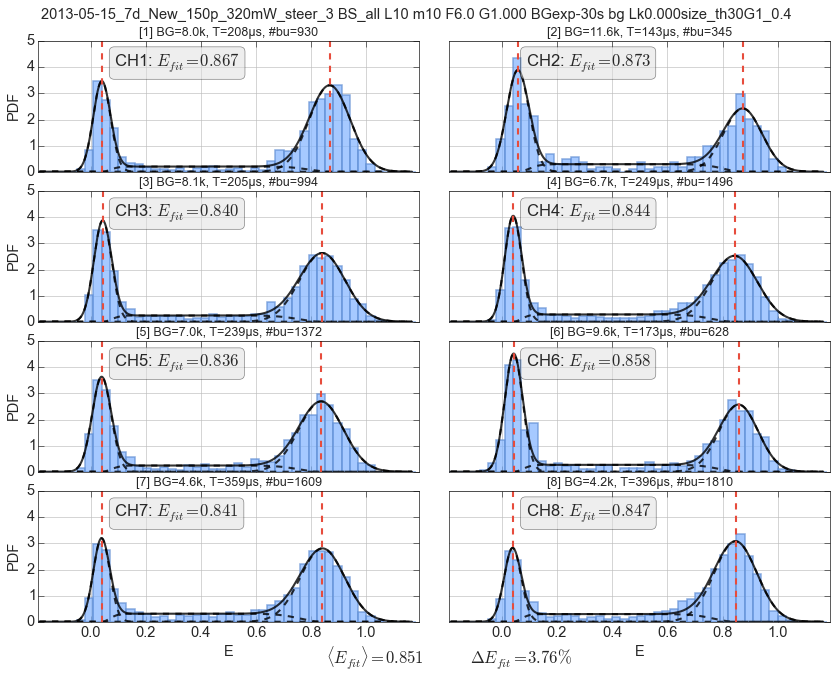

In [28]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='p2_center', show_fit_value=True);

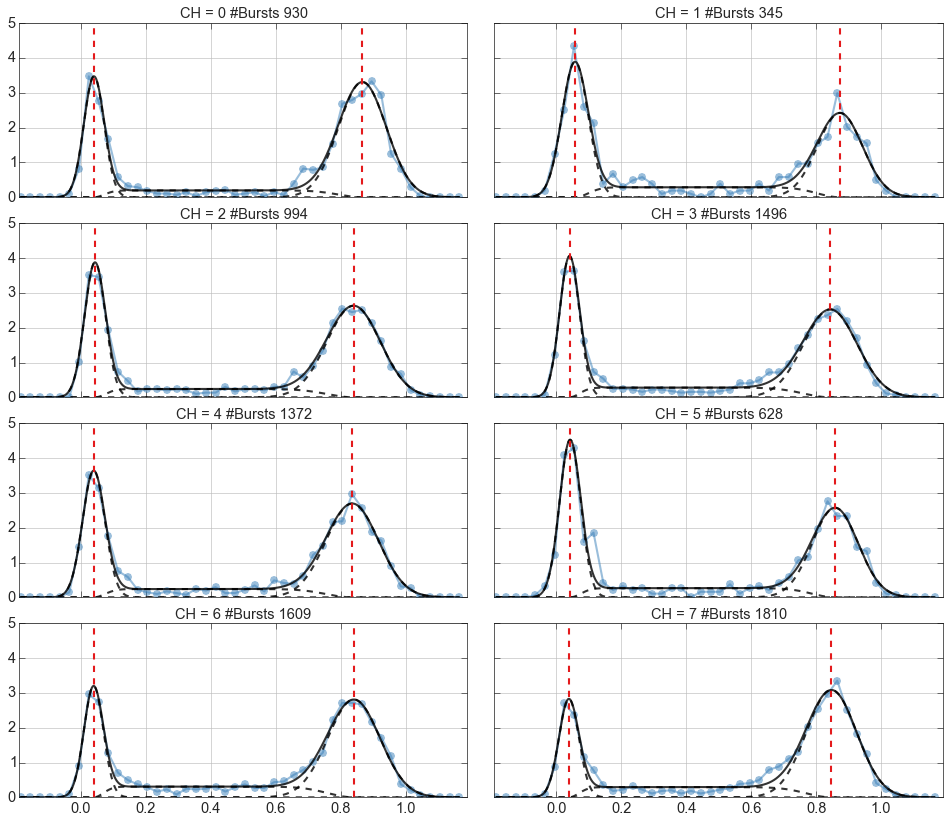

In [29]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12), sharex=True, sharey=True)
fig.subplots_adjust(left=0.08, right=0.96, top=0.93, bottom=0.07,
                    wspace=0.06, hspace=0.15)

for ich, ax in enumerate(axes.ravel()):
    mfit.plot_mfit(fitter, ich=ich, ax=ax)

## Compare the effect of burst-size weights

In [30]:
# bext.bursts_fitter(dx, weights=None)
# dx.E_fitter.fit_histogram(mfit.factory_two_gaussians())
# dplot(dx, hist_fret, weights=None, show_model=True, show_fit_stats=True, fit_from='p2_center');
# ylim(0, 6)
# fig_no_w = gcf()
# plt.close(fig_no_w)

# bext.bursts_fitter(dx, weights='size', gamma=0.43)
# dx.E_fitter.fit_histogram(mfit.factory_two_gaussians())
# dplot(dx, hist_fret, weights='size', gamma=0.43,
#       show_model=True, show_fit_stats=True, fit_from='p2_center');
# fig_w = gcf()
# plt.close(fig_w)

# def _plot(weights=False):
#     if weights:
#         display(fig_w)
#     else:
#         display(fig_no_w)

# interact(_plot, weights=False);

## 12bp sample

In [31]:
data_id = '12d'
if reload_data: 
    d12 = loader.photon_hdf5(files_dict[data_id])
    d12.calc_bg_cache(**bg_kwargs_auto)
if burst_search:
    d12.burst_search(m=10, F=F, dither=dither)
    if delete_ph_times: d12.delete('ph_times_m')

 * No cached BG rates, recomputing:


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [32]:
weights = 'size'

dfs12 = Sel(d12, select_bursts.size, th1=30, gamma1=gamma1_sel)
dfs12t = Sel(d12, select_bursts.topN_nda, N=3000, gamma1=gamma1_sel)
dx = dfs12

In [33]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_two_gaussians(add_bridge=True, p2_center=0.65)
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['p2_center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"


,0,1,2,3,4,5,6,7
12d,0.5912554,0.5799606,0.5725137,0.5749489,0.5635946,0.5562679,0.5655449,0.5629192


<IPython.core.display.Math object>

<IPython.core.display.Math object>

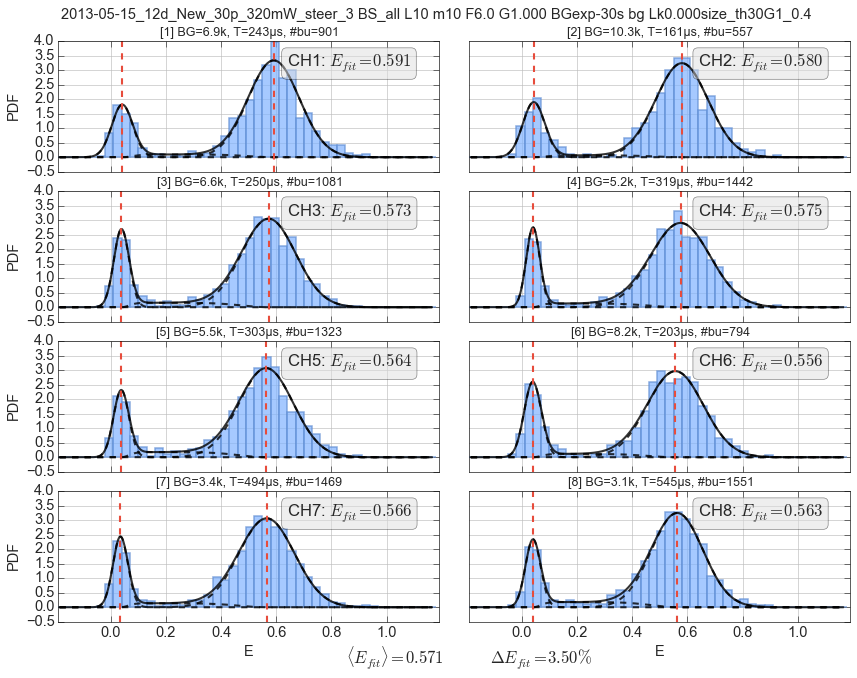

In [34]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='p2_center', show_fit_value=True);

## 17bp sample

In [35]:
# %cd $FRETBURSTS_DIR
# reload(mfit)

In [36]:
data_id = '17d'
if reload_data:
    d17 = loader.photon_hdf5(files_dict[data_id])
    d17.calc_bg_cache(**bg_kwargs_auto)
if burst_search:
    d17.burst_search(m=10, F=F, dither=dither)
    if delete_ph_times: d17.delete('ph_times_m')

 * No cached BG rates, recomputing:


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [37]:
dfs17 = Sel(d17, select_bursts.size, th1=30, gamma1=gamma1_sel)
dfs17t = Sel(d17, select_bursts.topN_nda, N=1000, gamma1=gamma1_sel)
dx = dfs17

In [38]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_two_gaussians(add_bridge=False, p2_center=0.4)
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['p2_center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"


,0,1,2,3,4,5,6,7
17d,0.3001135,0.2887786,0.2771308,0.2811914,0.2843952,0.2851429,0.2732507,0.2729703


<IPython.core.display.Math object>

<IPython.core.display.Math object>

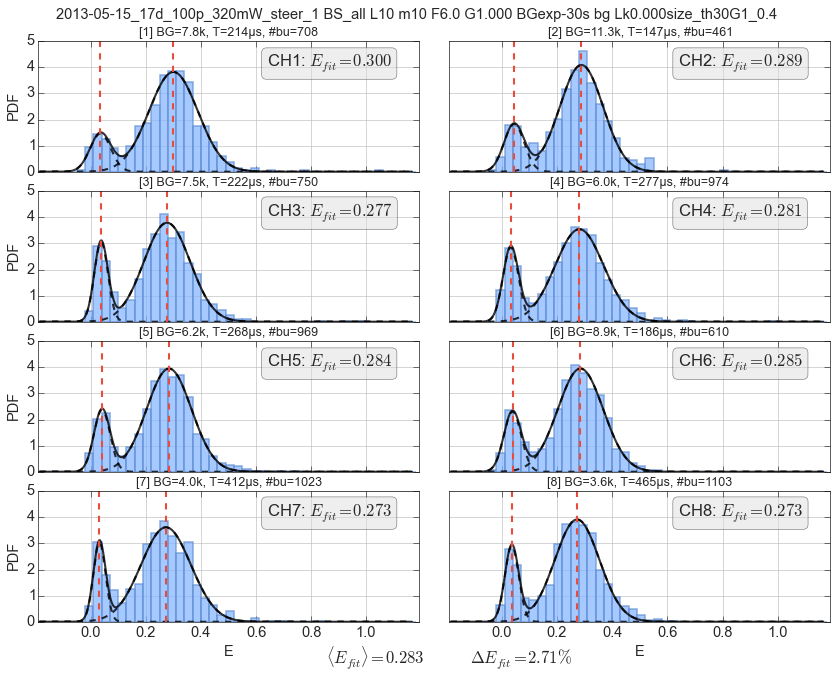

In [39]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='p2_center', show_fit_value=True);

## 22bp sample

In [40]:
data_id = '22d'
if reload_data:
    d22 = loader.photon_hdf5(files_dict[data_id])
    d22.calc_bg_cache(**bg_kwargs_auto)
if burst_search:
    d22.burst_search(m=10, F=F, dither=dither)
    if delete_ph_times: d22.delete('ph_times_m')

 * No cached BG rates, recomputing:


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [41]:
dfs22 = Sel(d22, select_bursts.size, th1=30, gamma1=gamma1_sel)
dfs22t = Sel(d22, select_bursts.topN_nda, N=300, gamma1=gamma1_sel)
dx = dfs22

In [42]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_gaussian()
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

 - Adding parameter "fwhm"


,0,1,2,3,4,5,6,7
22d,0.1334354,0.132961,0.1266976,0.1276445,0.1207222,0.1259264,0.1239956,0.1311375


<IPython.core.display.Math object>

<IPython.core.display.Math object>

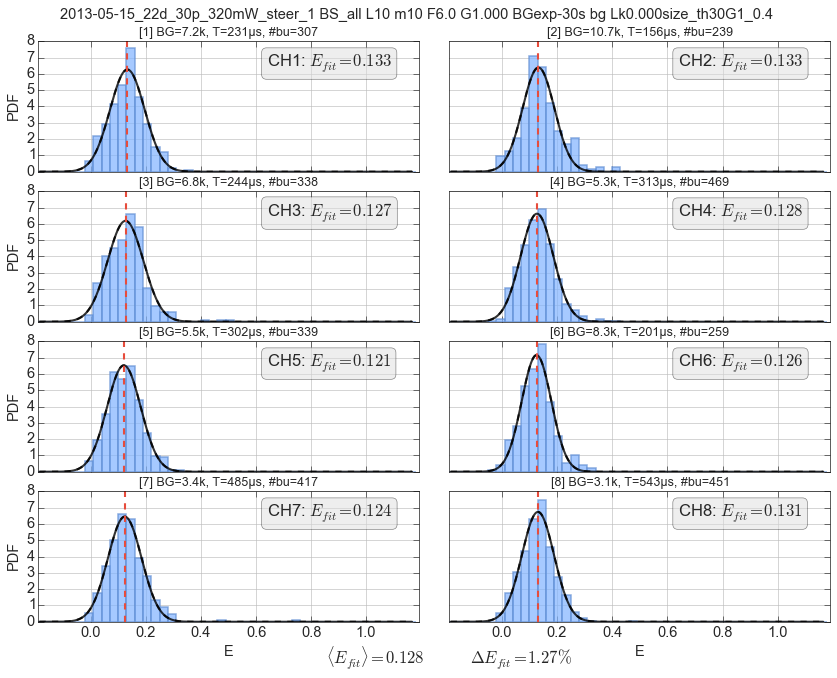

In [43]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='center', show_fit_value=True);

## 27bp sample

In [44]:
data_id = '27d'
if reload_data:
    d27 = loader.photon_hdf5(files_dict[data_id])
    d27.calc_bg_cache(**bg_kwargs_auto)
if burst_search:
    d27.burst_search(m=10, F=F, dither=dither)#, ph_sel=Ph_sel(Dex='Dem'))
    if delete_ph_times: d27.delete('ph_times_m')

 * No cached BG rates, recomputing:


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [45]:
dfs27 = Sel(d27, select_bursts.size, th1=30, gamma1=gamma1_sel)
dfs27t = Sel(d27, select_bursts.topN_nda, N=3000, gamma1=gamma1_sel)
dx = dfs27

In [46]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_asym_gaussian()
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

,0,1,2,3,4,5,6,7
27d,0.07793722,0.08191962,0.07210643,0.07894291,0.07198794,0.07468742,0.07268978,0.08001291


<IPython.core.display.Math object>

<IPython.core.display.Math object>

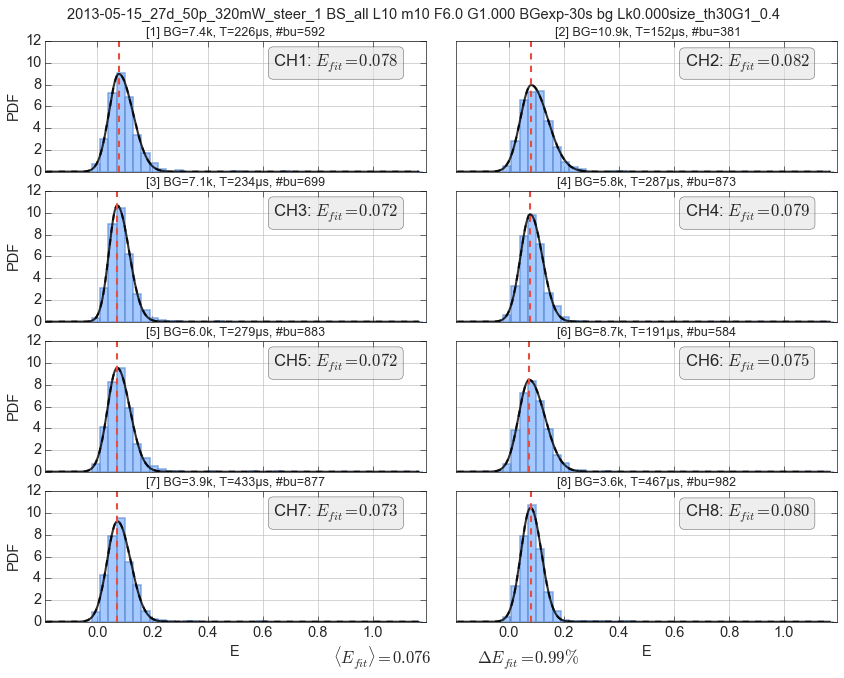

In [47]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='center', show_fit_value=True);

In [48]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_gaussian()
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=dir_ex_t)

 - Adding parameter "fwhm"


,0,1,2,3,4,5,6,7
27d,0.08605606,0.09455638,0.07934301,0.08310362,0.07781446,0.08493665,0.07844127,0.08224206


<IPython.core.display.Math object>

<IPython.core.display.Math object>

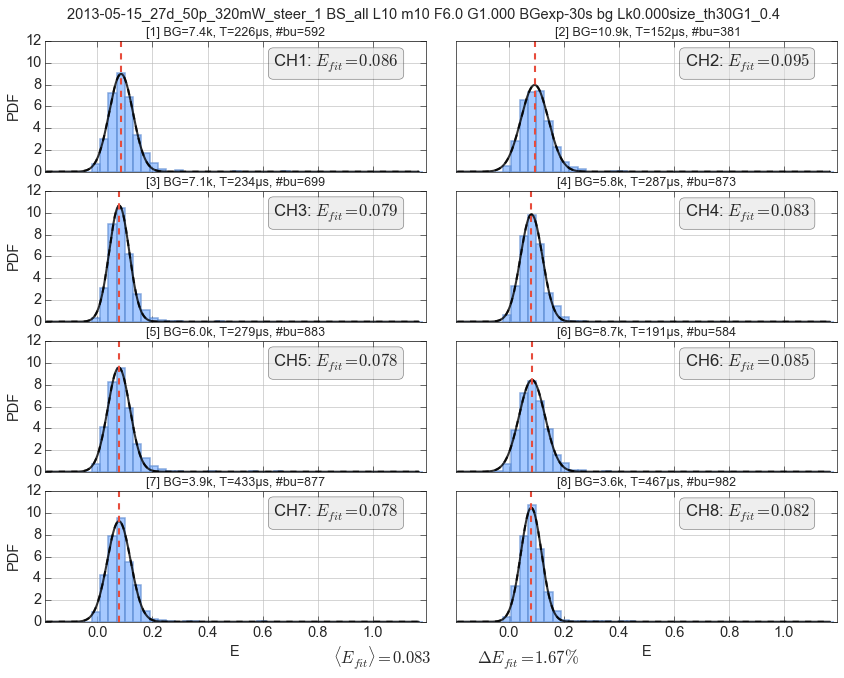

In [49]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='center', show_fit_value=True);

## D-only sample

In [50]:
data_id = 'DO'
if reload_data:
    do = loader.photon_hdf5(files_dict[data_id])
    do.calc_bg_cache(**bg_kwargs_auto)
if burst_search:
    do.burst_search(m=10, F=F, dither=dither, ph_sel=Ph_sel(Dex='Dem'))
    if delete_ph_times: do.delete('ph_times_m')

 * No cached BG rates, recomputing:


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [51]:
dfso = Sel(do, select_bursts.size, th1=30, gamma1=gamma1_sel)
dfsot = Sel(do, select_bursts.topN_nda, N=800, gamma1=gamma1_sel)
dx = dfso

In [52]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_asym_gaussian()
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=0)

,0,1,2,3,4,5,6,7
DO,0.02584577,0.03699048,0.02310543,0.02429668,0.02627323,0.0276103,0.0262958,0.01984579


<IPython.core.display.Math object>

<IPython.core.display.Math object>

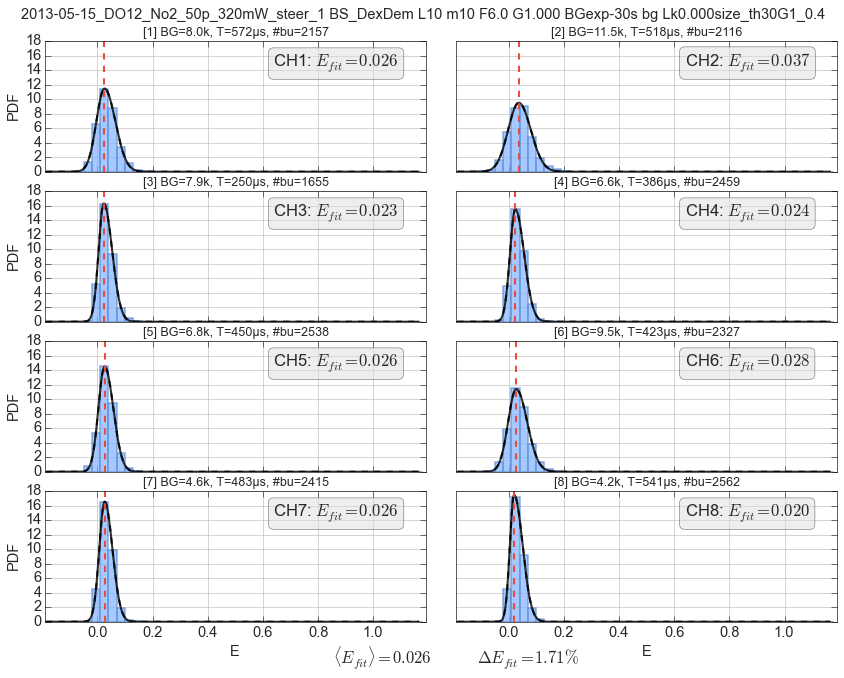

In [53]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='center', show_fit_value=True);

In [54]:
fitter = bext.bursts_fitter(dx)
fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
fitter.model = mfit.factory_gaussian()
fitter.fit_histogram()
E_pr_fret.loc[data_id] = fitter.params['center']
display(E_pr_fret.loc[[data_id]])
print_fit_report(E_pr_fret.loc[data_id], gamma=0.42, leakage=leakage, dir_ex_t=0)

 - Adding parameter "fwhm"


,0,1,2,3,4,5,6,7
DO,0.03141564,0.03966243,0.03061145,0.03182151,0.03145509,0.03335304,0.0317462,0.03052036


<IPython.core.display.Math object>

<IPython.core.display.Math object>

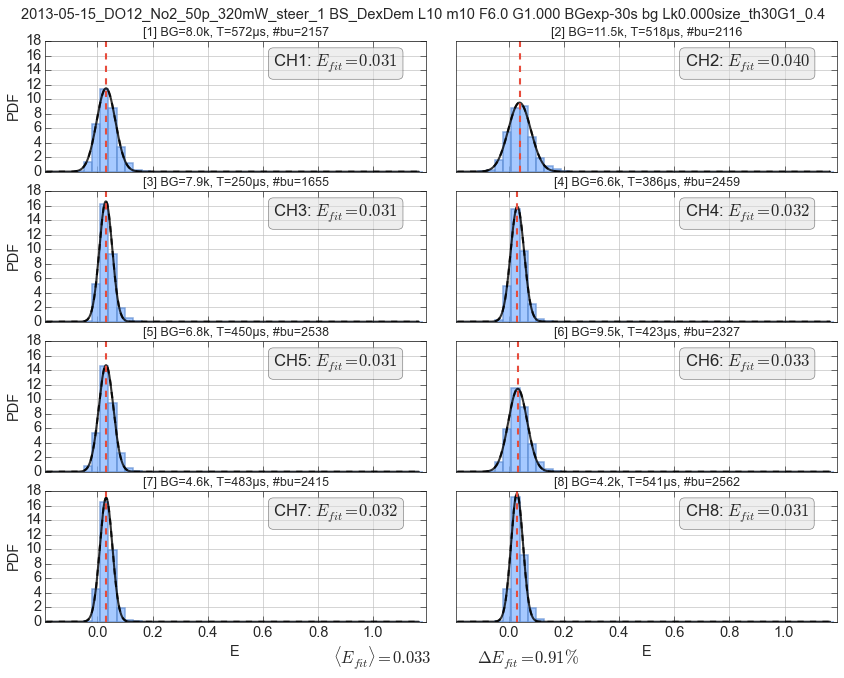

In [55]:
dplot(dx, hist_fret, show_model=True, 
      show_fit_stats=True, fit_from='center', show_fit_value=True);

##5-samples: global analysis

Proximity ratios fitted from multispot data:

In [56]:
E_pr_fret

,0,1,2,3,4,5,6,7
7d,0.866722,0.8732055,0.8397233,0.843603,0.835578,0.8582187,0.840571,0.8471466
12d,0.5912554,0.5799606,0.5725137,0.5749489,0.5635946,0.5562679,0.5655449,0.5629192
17d,0.3001135,0.2887786,0.2771308,0.2811914,0.2843952,0.2851429,0.2732507,0.2729703
DO,0.03141564,0.03966243,0.03061145,0.03182151,0.03145509,0.03335304,0.0317462,0.03052036
22d,0.1334354,0.132961,0.1266976,0.1276445,0.1207222,0.1259264,0.1239956,0.1311375
27d,0.08605606,0.09455638,0.07934301,0.08310362,0.07781446,0.08493665,0.07844127,0.08224206


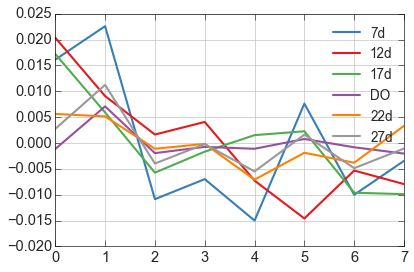

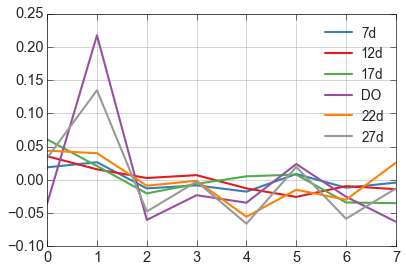

In [57]:
norm = (E_pr_fret.T - E_pr_fret.mean(1))#/E_pr_fret.mean(1)
norm_rel = (E_pr_fret.T - E_pr_fret.mean(1))/E_pr_fret.mean(1)
norm.plot()
norm_rel.plot()

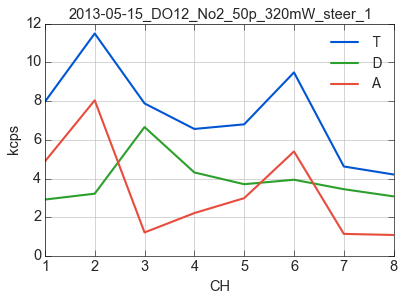

In [58]:
mch_plot_bg(dx)

> **NOTE:** The 27d and DO samples have a trend that correlates with the A-ch background. For these samples could be beneficial to use a D-only burst search.

> **NOTE 2**: Like observed during the leakage fit, even a D-only burst search results in +2% offset (DO) in CH1, this cannot be correlation with the A-background and must be slightly different gamma in the spot.

Corrected $E$ from μs-ALEX data:

In [59]:
data_file = 'results/usALEX-5samples-E-corrected-all-ph.txt'
data_alex = pd.read_csv(data_file, sep="\s+").set_index('sample')#[['E_pr_fret_kde']]
data_alex

,n_bursts_all,n_bursts_do,n_bursts_fret,E_kde_w,E_gauss_w,E_gauss_w_sig,E_gauss_w_err,S_kde,S_gauss,S_gauss_sig,S_gauss_err,E_pr_do_kde,nt_mean
sample,,,,,,,,,,,,,
7d,1167,583,541,0.9290,0.923612,0.060361,0.002595,0.5530,0.551031,0.099151,0.004263,0.0018,22.198900
12d,1303,329,944,0.7396,0.727858,0.091651,0.002983,0.5778,0.558006,0.105762,0.003442,0.0158,21.841737
17d,2482,463,1957,0.4266,0.422469,0.112972,0.002554,0.5458,0.539102,0.112595,0.002545,0.0124,21.054439
22d,2047,320,1665,0.1762,0.180234,0.077545,0.001900,0.5462,0.546301,0.114942,0.002817,0.0008,22.918132
27d,786,160,584,0.0820,0.082579,0.069136,0.002861,0.5190,0.560614,0.115021,0.004760,-0.0070,16.980705


In [60]:
E_alex = data_alex.E_gauss_w
E_alex

sample
7d     0.923612
12d    0.727858
17d    0.422469
22d    0.180234
27d    0.082579
Name: E_gauss_w, dtype: float64

## Multi-spot gamma fitting

In [61]:
import lmfit

In [62]:
def residuals(params, E_raw, E_ref):
    gamma = params['gamma'].value
    return E_ref - fretmath.correct_E_gamma_leak_dir(E_raw, leakage=leakage, gamma=gamma, dir_ex_t=dir_ex_t)

In [63]:
params = lmfit.Parameters()
params.add('gamma', value=0.5) 

In [64]:
E_pr_fret_mean = E_pr_fret.loc[E_pr_fret.index != 'DO'].mean(1)
E_pr_fret_mean

7d     0.850596
12d    0.570876
17d    0.282872
22d    0.127815
27d    0.083312
dtype: float64

In [65]:
m = lmfit.minimize(residuals, params, args=(E_pr_fret_mean, E_alex))
lmfit.report_fit(m.params, show_correl=False)

[[Variables]]
    gamma:   0.43751692 +/- 0.009370 (2.14%) (init= 0.5)


In [66]:
E_alex['17d'], E_pr_fret_mean['17d']

(0.42246930527800003, 0.2828716731844374)

In [67]:
m = lmfit.minimize(residuals, params, args=(np.array([E_pr_fret_mean['17d']]), np.array([E_alex['17d']])))
lmfit.report_fit(m.params, show_correl=False)

[[Variables]]
    gamma:   0.44469116 +/- inf      (inf%) (init= 0.4375169)


In [68]:
print 'Fitted gamma:', m.params['gamma'].value

Fitted gamma: 0.44469116519


In [69]:
multispot_gamma = m.values['gamma']
multispot_gamma

0.44469116518950569

In [70]:
E_fret_mch = fretmath.correct_E_gamma_leak_dir(E_pr_fret, leakage=leakage, dir_ex_t=dir_ex_t, 
                                               gamma=multispot_gamma
                                               ).loc[E_pr_fret.index != 'DO']
E_fret_mch

,0,1,2,3,4,5,6,7
7d,0.9327001,0.9362381,0.9176464,0.9198421,0.9152882,0.9280153,0.9181271,0.9218378
12d,0.7495221,0.7403269,0.7341749,0.7361945,0.726711,0.7205005,0.7283522,0.7261416
17d,0.4460853,0.4306528,0.4144208,0.4201234,0.4245895,0.4256275,0.4089273,0.4085286
22d,0.176785,0.1758645,0.1636114,0.1654757,0.1517471,0.1620898,0.1582679,0.1723162
27d,0.07935195,0.09768924,0.06458707,0.0728895,0.06118944,0.07690746,0.06258431,0.07099446


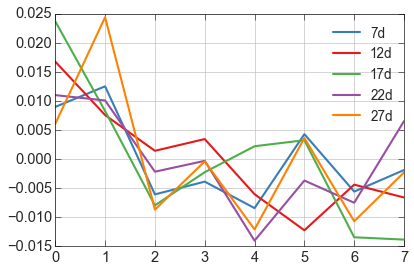

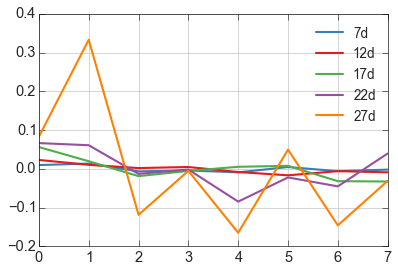

In [71]:
norm = (E_fret_mch.T - E_fret_mch.mean(1))#/E_pr_fret.mean(1)
norm_rel = (E_fret_mch.T - E_fret_mch.mean(1))/E_fret_mch.mean(1)
norm.plot()
norm_rel.plot()

## Merging the channels

Merge the data of the different channels:

In [72]:
dfs7c = dfs7.collapse()
dfs12c = dfs12.collapse()
dfs17c = dfs17.collapse()
dfs22c = dfs22.collapse()
dfs27c = dfs27.collapse()
dfsoc = dfso.collapse()

## Define samples lists

Define list of results and labels:

In [73]:
d_samples = [dfs7, dfs12, dfs17, dfs22, dfs27, dfso]
d_samples_topN = [dfs7t, dfs12t, dfs17t, dfs22t, dfs27t, dfsot]
d_samples_c = [dfs7c, dfs12c, dfs17c, dfs22c, dfs27c ]
d_labels = ['7d', '12d', '17d', '22d', '27d', 'DO']
CH = np.arange(1, 9)
CH_labels = ['CH%d' % i for i in CH]
dist_s_bp = [7, 12, 17, 22, 27]

Print a summary of current processed data:

In [74]:
def print_params(d_samples, d_labels, status=False):
    print 'Sample              Model             Ph_sel'
    for dx, name in zip(d_samples, d_labels):
        print "%3s %25s %35s" % (name, dx.E_fitter.model.name, dx.ph_sel)
    if status:
        print
        for dx, name in zip(d_samples, d_labels):
            print dx.status()

In [75]:
print_params(d_samples, d_labels, 1)

Sample              Model             Ph_sel
 7d ((Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_')) + Model(bridge_function, prefix='br_'))                                 all
12d ((Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_')) + Model(bridge_function, prefix='br_'))                                 all
17d (Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_'))                                 all
22d           Model(gaussian)                                 all
27d           Model(gaussian)                                 all
 DO           Model(gaussian)                              DexDem

2013-05-15_7d_New_150p_320mW_steer_3 BS_all L10 m10 F6.0 G1.000 BGexp-30s bg Lk0.000size_th30G1_0.4
2013-05-15_12d_New_30p_320mW_steer_3 BS_all L10 m10 F6.0 G1.000 BGexp-30s bg Lk0.000size_th30G1_0.4
2013-05-15_17d_100p_320mW_steer_1 BS_all L10 m10 F6.0 G1.000 BGexp-30s bg Lk0.000size_th30G1_0.4
2013-05-15_22d_30p_320mW_steer_1 BS_all L10 m10 F6.0 G1.000 BGexp

###Plot FRET vs distance

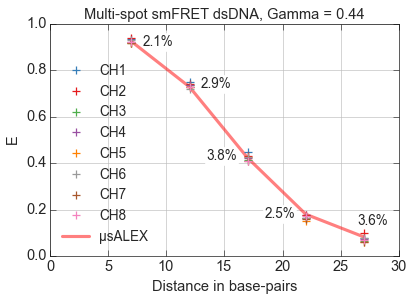

In [76]:
text_pos = {'7d': (10.5, 0.92), '12d': (15.5, 0.74), '17d': (16, 0.43), '22d': (21, 0.18), '27d': (29, 0.15)}
text_kwargs = dict(ha='right', va='center', 
                   bbox=dict(facecolor='white', edgecolor='white'),
                   zorder=2, fontsize=fontsize-1,
                   )
dfun = lambda E_fit: 100*(E_fit.max()-E_fit.min())
fig, ax = plt.subplots()

ax.plot(dist_s_bp, E_fret_mch, '+', lw=2, mew=1.2, ms=8, zorder=4)
ax.plot(dist_s_bp, E_alex, '-', lw=3, mew=0, alpha=0.5, color='r', zorder=3)

plt.title('Multi-spot smFRET dsDNA, Gamma = %.2f' % multispot_gamma)
plt.xlabel('Distance in base-pairs', fontsize=fontsize); 
plt.ylabel('E', fontsize=fontsize)
plt.ylim(0, 1); plt.xlim(0, 30)
plt.grid(True)
plt.legend(['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8', u'μsALEX'], 
       fancybox=True, prop={'size':fontsize-1},
       #loc='upper right', bbox_to_anchor=(1.05, 1))
       loc='best')

if deviance_plot:
    for sample in E_fret_mch.index:
        delta = dfun(E_fret_mch.loc[sample])
        text_kwargs.update(
                          s="%.1f%%" % delta, 
                          #s="$\Delta = %.1f%%$" % delta, 
                          x=text_pos[sample][0],
                          y=text_pos[sample][1],
                          )
        ax.text(**text_kwargs)

#ax.set_axisbelow(True)
#if save_figure: plt.savefig("FRET vs distance - %s SPW F%d.png" % (fret_gen_fit_func.__name__, F))
#plt.savefig(PLOT_DIR+"FRET vs distance - Gpost_th30.png", dpi=200, bbox_inches='tight')

In [77]:
E_alex

sample
7d     0.923612
12d    0.727858
17d    0.422469
22d    0.180234
27d    0.082579
Name: E_gauss_w, dtype: float64

In [78]:
E_fret_mch.mean(1)

7d     0.923712
12d    0.732740
17d    0.422369
22d    0.165770
27d    0.073274
dtype: float64

> **NOTE** The fact the we fit the 27d with a single Gaussian may account for the slight shift of the FRET efficiency compared to the us-ALEX measurements. The shift is bigger when using an asymmetric-gaussian model for multi-spot fitting. Probably, for consistency with us-ALEX fitting we should stick to the plain gaussian.

In [79]:
red, blue, green, grey, black, brown, purple, orange = ['#e41a1c', '#3771c8', '#2ca02c', '#999999', 
                                        '#333333', '#a65628', '#984ea3', '#ff7f00']
colors_cycle = [blue, red, green, orange, grey, brown, black, purple]
mpl.rcParams['axes.color_cycle'] = colors_cycle

In [80]:
stop

NameError: name 'stop' is not defined

##D-only fraction

In [ ]:
fit_type = '2gauss'
hist_weights = 'size'

In [ ]:
dfs7t = Sel(d7, select_bursts.topN_nda, N=1500, gamma1=gamma1_sel)
dfs12t = Sel(d12, select_bursts.topN_nda, N=2000, gamma1=gamma1_sel)
dfs17t = Sel(d17, select_bursts.topN_nda, N=1000, gamma1=gamma1_sel)

In [ ]:
# %cd $FRETBURSTS_DIR
# reload(mfit)

In [ ]:
dx = dfs7t
fit = mfit.MultiFitter(dx.E)
fit.set_weights_func(weight_func=bl.fret_fit.get_weights,
                        weight_kwargs = dict(weights='size', nd=dx.nd, na=dx.na, 
                                             gamma=multispot_gamma))
fit.histogram(bin_width=0.03)
fit.fit_histogram(mfit.factory_two_gaussians)
fit.params

In [ ]:
dfs7t.fit_E_generic(fit_fun=bl.two_gaussian_fit_hist_min_ab, 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])

do_frac_th7t, do_frac_fit7t = donly_fraction(dfs7t, E_th=0.35, fit=True, num_ph=True, gamma=gamma_fit)

In [ ]:
dfs7t.fit_E_generic(fit_fun=bl.two_gaussian_fit_hist_min_ab, 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])

do_frac_th7t, do_frac_fit7t = donly_fraction(dfs7t, E_th=0.35, fit=True, num_ph=True, gamma=gamma_fit)

In [ ]:
dfs12t.fit_E_generic(E1=fret_fit_E_raw[fit_type]['12d'], fit_fun=fret_fit_func[fit_type], 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])

do_frac_th12t, do_frac_fit12t, = donly_fraction(dfs12t, E_th=0.2, fit=True, num_ph=True, gamma=gamma_fit)

In [ ]:
dfs17t.fit_E_generic(E1=fret_fit_E_raw[fit_type]['17d'], fit_fun=fret_fit_func[fit_type], 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])

do_frac_th17t, do_frac_fit17t, = donly_fraction(dfs17t, E_th=0.075, fit=True, num_ph=True, gamma=gamma_fit)

In [ ]:
fit_type = '2gauss'
hist_weights = 'size'

dfs7.fit_E_generic(E1=fret_fit_E_raw[fit_type]['7d'], fit_fun=fret_fit_func[fit_type], 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])
dfs12.fit_E_generic(E1=fret_fit_E_raw[fit_type]['12d'], fit_fun=fret_fit_func[fit_type], 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])
dfs17.fit_E_generic(E1=fret_fit_E_raw[fit_type]['17d'], fit_fun=fret_fit_func[fit_type], 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])

do_frac_th7, do_frac_fit7 = donly_fraction(dfs7, E_th=0.35, fit=True, num_ph=True, gamma=gamma_fit)
do_frac_th12, do_frac_fit12 = donly_fraction(dfs12, E_th=0.2, fit=True, num_ph=True, gamma=gamma_fit)
do_frac_th17, do_frac_fit17 = donly_fraction(dfs17, E_th=0.075, fit=True, num_ph=True, gamma=gamma_fit)

dfs7t.fit_E_generic(E1=fret_fit_E_raw[fit_type]['7d'], fit_fun=fret_fit_func[fit_type], 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])
dfs12t.fit_E_generic(E1=fret_fit_E_raw[fit_type]['12d'], fit_fun=fret_fit_func[fit_type], 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])
dfs17t.fit_E_generic(E1=fret_fit_E_raw[fit_type]['17d'], fit_fun=fret_fit_func[fit_type], 
                   weights=hist_weights, gamma=gamma_fit, **fret_fit_kwargs[fit_type])

do_frac_th7t, do_frac_fit7t = donly_fraction(dfs7t, E_th=0.35, fit=True, num_ph=True, gamma=gamma_fit)
do_frac_th12t, do_frac_fit12t, = donly_fraction(dfs12t, E_th=0.2, fit=True, num_ph=True, gamma=gamma_fit)
do_frac_th17t, do_frac_fit17t, = donly_fraction(dfs17t, E_th=0.075, fit=True, num_ph=True, gamma=gamma_fit)

In [ ]:
do_frac_topN = np.vstack([do_frac_fit7t, do_frac_fit12t, do_frac_fit17t])

In [ ]:
plot(do_frac_topN, '-o')
plt.title('D-only fraction vs sample');
xlim(-0.5, 2.5)
plt.xticks([0, 1, 2])
gca().set_xticklabels(['7bp', '12bp', '17bp']);

In [ ]:
do_frac_th30 = np.vstack([do_frac_fit7, do_frac_fit12, do_frac_fit17])

In [ ]:
do_frac_topN

In [ ]:
do_frac_th30

In [ ]:
title_ = 'D-only fraction vs CH (2gauss, th30)'
print title_, '\n'

for s in do_frac_th30:
    print ''.join(["%.2f, "]*8) % tuple(s)

print '      Mean Std.Dev'
for s,l in zip(do_frac_th30, d_labels):
    print "%3s:  %.1f  %.1f " % (l, s.mean()*100, s.std()*100)

plot(do_frac_th30.T[:, :3], '-s')
plt.title(title_)
plt.ylim(0.0,0.5)
plt.xlim(-0.5, 7.5)
plt.legend(['7d', '12d', '17d'], loc='lower right', ncol=3)
#plt.savefig(PLOT_DIR+'D-only fraction 3sample th30.png', dpi=200, bbox_inches='tight');

In [ ]:
title_ = 'D-only fraction vs CH (2gauss,topN)'
print title_, '\n'

for s in do_frac_topN:
    print ''.join(["%.2f, "]*8) % tuple(s)

print '      Mean Std.Dev'
for s,l in zip(do_frac_topN, d_labels):
    print "%3s:  %.1f  %.1f " % (l, s.mean()*100, s.std()*100)

plot(do_frac_topN.T[:, :3], '-s')
plt.title(title_)
plt.ylim(0.0,0.5)
plt.xlim(-0.5, 7.5)
plt.legend(['7d', '12d', '17d'], loc='lower right', ncol=3)
#plt.savefig(PLOT_DIR+'D-only fraction 3sample topN.png', dpi=200, bbox_inches='tight');

In [ ]:
a = np.hstack((do_frac_topN.T[:, :3], do_frac_th30.T[:, :3]))
bp = plt.boxplot(a[:, (0, 3, 1, 4, 2, 5)], whis=np.inf)
plt.gca().set_xticklabels(['7d topN', '7d th30', '12d topN', '12d th30', '17d topN', '17d th30',],
                          rotation=45)
plt.setp(bp['boxes'], color=blue)
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
plt.setp(bp['medians'], color='red')
plt.title('D-only fraction')
#plt.savefig(PLOT_DIR+'D-only fraction 3sample boxplot.png', dpi=200, bbox_inches='tight');

#All samples Plots

In [ ]:
def hist_fret_nb(i, b, d, bins=None, binw=0.02,
        no_text=False, normed=False, weights=None, gamma=1., ax=None, 
        noylabel=False, **kwargs):
    """Plot the FRET histogram and optionally the fitted model
    """
    if bins is None: bins = r_[-0.2:1.2:binw]
    if ax is None: ax = plt.subplot(111)
    plot_style = dict(histtype='step', lw=1.2,
                      #edgecolor='white'
                      )
    plot_style.update(**kwargs)  # kwargs overwrite plot_style
    if weights is not None:
        w = fret_fit.get_weights(d.nd[i], d.na[i], weights, gamma=gamma)
        w *= w.size/w.sum()
        plot_style.update(weights=w)
    H = ax.hist(1.*d.E[i], bins=bins, normed=normed, **plot_style)
    plt.xlabel('FRET Efficiency')
    if not noylabel:
        plt.ylabel('# Bursts')
        if normed: plt.ylabel('PDF')

def mhist_fret(d, **kwargs):
    for ich in xrange(d.nch):
        hist_fret_nb(ich, d.mburst[ich], d, **kwargs)
            
def get_empty_ax(fig, bgcolor='none'):
    ax = fig.add_subplot(111)
    ax.set_zorder(-1)
    ax.set_axis_bgcolor(bgcolor)
    ax.grid(False)
    #ax.set_frame_on(False)
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    return ax

In [ ]:
# # Fit params in all measurements
# # Note: requires using 2gauss fit in all the measurements
# FP = zeros((8, 5, 5))
# for ich in range(8):
#     FP[ich] = [d.fit_E_res[ich] for d in DD[:-1]]

# plot(FP[:,:,4].T)
# legend(['CH{}'.format(i) for i in xrange(1,9)], loc='best', ncol=2, frameon=False)

In [ ]:
TT = r_[[int(d.time_max()) for d in d_samples]]
print 'Measurement time:', TT

In [ ]:
print '#Bursts (CH1):', [d.nd[0].size for d in d_samples]

In [ ]:
# Bursts per second
BPS = np.zeros((8,6))
for ich in range(8):
    bps = [d.nd[ich].size/float(t) for d,t in zip(d_samples, TT)]
    print '#Bursts/s (CH%d): '%(ich+1), ''.join(['%5.2f  ' % x for x in bps])
    BPS[ich] = bps

In [ ]:
# BG in all measurements
BG_t = np.zeros((8,6))
for ich in range(8):
    bg = [np.mean(d.bg[ich]) for d in d_samples]
    print 'BG tot (CH%d): '%(ich+1), ''.join(['%5d  ' % x for x in bg])
    BG_t[ich] = bg

**NOTE:** The background is more or less constant across the measuments but the BPS increases in all the ch (regardless of BG). So in 22 and 27 measurements we **the concentration is higher**. 

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].plot(BPS.T)
ax[0].set_title('#Bursts/s vs measurement')
ax[0].legend(['CH{}'.format(i) for i in xrange(1,9)], loc='upper center', ncol=2, frameon=False)
ax[0].set_xticklabels(d_labels)

ax[1].plot(BG_t.T)
ax[1].set_title('BG(cps) vs measurement')
ax[1].legend(['CH{}'.format(i) for i in xrange(1,9)], loc='lower center', ncol=4, frameon=False)
ax[1].set_xticklabels(d_labels)
ax[1].set_ylim(0)

In [ ]:
# Burst sizes in all measurements
BS = np.zeros((8,6))
for ich in range(8):
    bs = [np.mean(d.nt[ich]) for d in d_samples]
    print 'Burst size (CH%d): '%(ich+1), ''.join(['%5d  ' % x for x in bs])
    BS[ich] = bs

In [ ]:
def corr_bs(nt_raw, E_raw, gamma):
    return nt_raw*(gamma/(1+(gamma-1)*bl.gamma_correct_E(E_raw, gamma)))

# Gamma-corrected burst size in all measurements
GBS = np.zeros((8,6))
for ich in range(8):
    gbs = [np.mean(corr_bs(d.nt[ich], d.E[ich], gamma_post) ) for d in d_samples]
    print 'Gamma-corrected burst sizes (CH%d): '%(ich+1), ''.join(['%5d  ' % x for x in gbs])
    GBS[ich] = gbs

In [ ]:
plot(BS.T)
plt.title(u'Mean-burst-sizes vs measurement (γ=1)')
plt.legend(['CH{}'.format(i) for i in xrange(1,9)], loc='lower center', ncol=4, frameon=False)
gca().set_xticklabels(d_labels)
plt.ylim(0);
print 'WARNING: Be all the meas. use the same TH!!!'

In [ ]:
plot(GBS.T)
plt.title('Corrected mean-burst-sizes vs measurement')
plt.legend(['CH{}'.format(i) for i in xrange(1,9)], loc='lower center', ncol=4, frameon=False)
gca().set_xticklabels(d_labels)
plt.ylim(0);
print 'WARNING: Be all the meas. use the same TH!!!'

In [ ]:
for dx, label in zip(d_samples_c, d_labels):
    x = bl.b_start(dx.mburst[0])*dx.clk_p
    y = np.ones(x.size)
    plot(x, np.cumsum(y), label=label)
plt.title('Burst accumulation')
plt.ylabel('# Bursts')
plt.xlabel('Time (s)')
plt.legend();
plt.xlim(0, 180)

In [ ]:
dx = dfs7

for ich in xrange(8):
    x = bl.b_start(dx.mburst[ich])*dx.clk_p
    y = np.ones(x.size)
    plot(x, np.cumsum(y))
plt.title('Burst accumulation')
plt.ylabel('# Bursts')
plt.xlabel('Time (s)')

#FRET Histograms

In [ ]:
print_params(d_samples, d_labels, status=True)

In [ ]:
#CC = ['b', 'r', 'g', 'c', 'm', 'gray']
d_colors = ['#0055d4', '#d40000', '#44aa00', '#4400aa', '#d45500', 'gray']

face_colors =  mpl.colors.colorConverter.to_rgba_array(d_colors)
edge_colors = face_colors.copy()
face_colors[:,3] = 0.05
edge_colors[:,3] = 0.4

In [ ]:
# FRET hist: all in one plot
for d,c in zip(d_samples[:-1], d_colors[:-1]):
    mhist_fret(d, color=c, lw=2, alpha=0.3, binw=0.02, normed=True)
    #ylim(0,100)
    #legend(['CH{}'.format(i) for i in xrange(1,9)], loc='upper center', ncol=2, frameon=False)
#ylim(0,300)
#savefig(PLOT_DIR+'FRET Hist 5samples.svg', dpi=200, bbox_inches='tight')

In [ ]:
# FRET hist: 6 subplots
fig, AX = plt.subplots(6, 1, sharex=True, figsize=(6,5.5))
for d, la, fc, ec, ax in zip(d_samples, d_labels, face_colors, edge_colors, AX):
    
    mhist_fret(d, lw=1., fc=fc, ec=ec, binw=0.02, normed=True,  
               ax=ax, histtype='stepfilled', noylabel=True)
    ax.set_yticks([])
    xtext = 0.6 if la.startswith('7') else 0.8
    ax.text(xtext, 0.6, la,
            transform = ax.transAxes, #fontsize=16,
            bbox=dict(boxstyle='round', facecolor='#efefef', alpha=1.))
plt.subplots_adjust(hspace = 0)
plt.xlim(-0.15,1.1)
ax = get_empty_ax(fig)
ax.set_ylabel('# Bursts')
#savefig(PLOT_DIR+'FRET Hist 5samples stacked post normed2.png', dpi=200, bbox_inches='tight')

In [ ]:
# FRET hist: 6 subplots
fig, AX = plt.subplots(6, 1, sharex=True, figsize=(6,5.5))
ticks_sample = [[0, 50, 100],
                [0, 50, 100],
                [0, 50],
                [0, 50],
                [0, 100],
                [0, 500]]

for d, la, fc, ec, ax, ti in zip(d_samples, d_labels, face_colors, edge_colors, AX, ticks_sample):
    
    mhist_fret(d, lw=1., fc=fc, ec=ec, binw=0.02, normed=False,  
               ax=ax, histtype='stepfilled', noylabel=True)
    ax.set_yticks(ti)
    #ax.set_yticklabels([])
    xtext = 0.6 if la.startswith('7') else 0.8
    ax.text(xtext, 0.6, la,
            transform = ax.transAxes, #fontsize=16,
            bbox=dict(boxstyle='round', facecolor='#efefef', alpha=1.))
plt.subplots_adjust(hspace = 0)
plt.xlim(-0.15,1.1)
ax = get_empty_ax(fig)
ax.set_ylabel('# Bursts')
#plt.savefig(PLOT_DIR+'FRET Hist 5samples stacked post NoNormed.png', dpi=200, bbox_inches='tight')

In [ ]:
print 'OK'

# Notebook style

In [ ]:
from IPython.core.display import HTML
HTML(open("./styles/custom.css", "r").read())